# Clustering Algorithms

## K Means

Clustering refers to a very broad set of techniques for finding subgroups, or clusters, in a data set. When we cluster the observations of a data set, we seek to partition them into distinct groups so that the observations within each group are quite similar to each other, while observations in different groups are quite different from each other.

We begin by defining some notation. Starting with a dataset of $n$ observations on $p$ features, firstly we choose a number of clusters $K$. Let $C_1, \ldots, C_K$ denote sets containing the indices of the observations in each cluster. These sets satisfy two properties:
1. $C_1 \cup C_2 \cup \ldots \cup C_K = \{1, \ldots , n\}$. In other words, each observation
belongs to at least one of the K clusters.
2. $C_k \cap C_k'  = \varnothing\; \forall\; k \neq k'$ . In other words, the clusters are non-
overlapping: no observation belongs to more than one cluster.

For instance, if the ith observation is in the kth cluster, then i ∈ C k . The
idea behind K-means clustering is that a *good clustering* is one for which *the
within-cluster variation is as small as possible*.

Using the Euclidean distance between points as our measure of variation, the optimization problem is defined as follows. Choose $C_1, \ldots, C_K$ to minimize:
$$
\sum_{k=1}^K\frac{1}{|C_k|}\sum_{i,i'\in C_k}\sum_{j=1}^p(x_{ij}-x_{i'j})^2\\
=\sum_{k=1}^K 2\sum_{i\in C_k}\sum_{j=1}^p(x_{ij}-\bar{x}_{kj})^2\\
$$
where $\bar{x}_{kj}=\frac{1}{|C_k|}\sum_{i\in C_k}x_{ij}$ is the mean for feature $j$ in the cluster $C_k$. Noting the **equivalence between minimizing the within-cluster variability and minimizing the distance to the centroid for each cluster** is key.

This paves the way for the core algorithm behind K means:
1. Randomly assign a number, from 1 to $K$, to each of the observations.
These serve as initial cluster assignments for the observations.
2. Iterate until the cluster assignments stop changing:
    1. For each of the K clusters, compute the cluster centroid. The $k$th cluster centroid is the vector of the $p$ feature means for the observations in the $k$th cluster.
    2. Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance).
    
Let's take a closer look at the algorithm in the context of a simple dataset.

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Construct a simple dataset of four clusters.

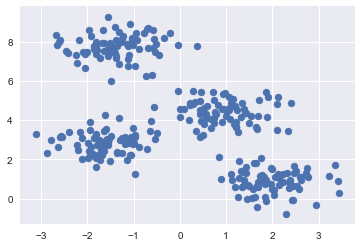

In [224]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [225]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

We can visualize the assigned clusters and cluster centroids.

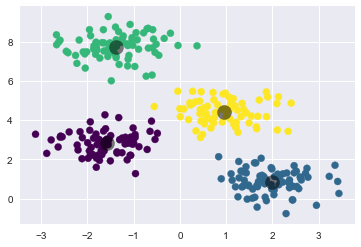

In [227]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black',
            s=200, alpha=0.5);

## K-Means Algorithm: Expectation-Maximization

K-means is a particularly simple and easy-to-understand application of *Expectation Maximization algorithm*, and we will walk through it briefly here. We'll represent the K-means algorithm covered earlier explicitly in terms of *expectation* and *maximization* below:

Initialize a set of $K$ cluster centers.
Repeat until converged:
1. Expectation Step: assign points to the nearest cluster center
2. Maximization Step: set the cluster centers to the mean of each cluster given the new cluster assignments

Here the "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

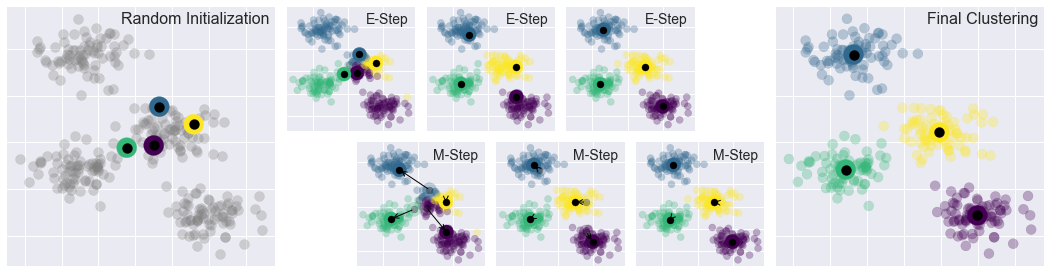

In [15]:
from utils import plot_kmeans_EM

plot_kmeans_EM()

In fact, we can implement a simple version of the expectation-maximization algorithm directly:

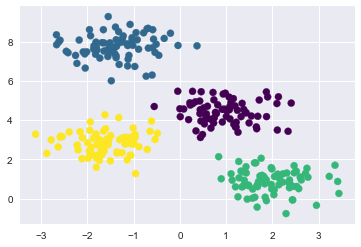

In [110]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Drawbacks of expectation-maximization

#### The globally optimal result may not be achieved
The intial set of cluster centers selected can influence the final set of clusters.

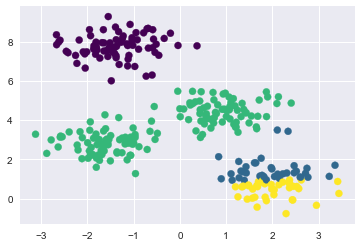

In [111]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### The number of clusters must be selected before running K Means
We can impose beliefs about the number of clusters that do not fit the data.

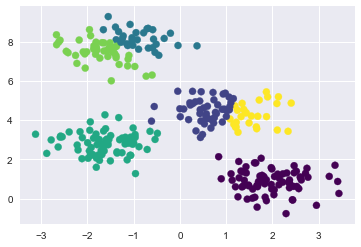

In [112]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### K Means is limited to linear cluster boundaries
The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries (e.g. points on manifolds).

In [179]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

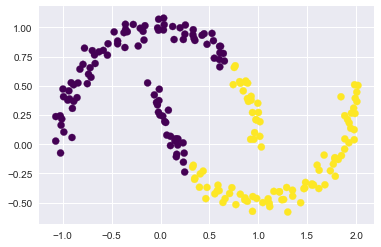

In [180]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Every point in the dataset is assumed to belong to a cluster

In [181]:
np.random.seed(42)
n_noise = 50
X_new = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], n_noise)
y_new = np.repeat(2, n_noise)

X = np.vstack((X, X_new))
y = np.vstack((y.reshape((-1, 1)), y_new.reshape((-1, 1))))

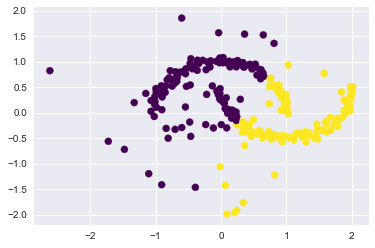

In [182]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## DBSCAN

DBSCAN is a popular *density-based* clustering algorithm which is fundamentally very different from K-means.

* In K-means clustering, each cluster is represented by a centroid, and points are assigned to whichever centroid they are closest to. In DBSCAN, there are no centroids, and clusters are formed by linking nearby points to one another.
* K-means requires specifying the number of clusters, $K$. DBSCAN does not, but does require specifying two parameters which influence the decision of whether two nearby points should be linked into the same cluster. These two parameters are a distance threshold, $\epsilon$ (epsilon), and “MinPts” (minimum number of points), to be explained.
* K-means runs over many iterations to converge on a good set of clusters, and cluster assignments can change on each iteration. DBSCAN makes only a single pass through the data, and once a point has been assigned to a particular cluster, it never changes.

The language of trees is quite natural for describing cluster growth in DBSCAN. It starts with an arbitrary seed point which has at least MinPts points nearby within a distance (or “radius”) of $\epsilon$. We do a *breadth-first search* along each of these nearby points. For a given nearby point, we check how many points it has within its radius. If it has fewer than MinPts neighbors, this point becomes a leaf–we don’t continue to grow the cluster from it. If it does have at least MinPts, however, then it’s a branch, and we add all of its neighbors to the FIFO queue of our breadth-first search.

Once the breadth-first search is complete, we’re done with that cluster, and we never revisit any of the points in it. We pick a new arbitrary seed point (which isn’t already part of another cluster), and grow the next cluster. This continues until all of the points have been assigned.

There is one other novel aspect of DBSCAN which affects the algorithm. If a point has fewer than MinPts neighbors, AND it’s not a leaf node of another cluster, then it’s labeled as a “Noise” point that doesn’t belong to any cluster.

Noise points are identified as part of the process of selecting a new seed–if a particular seed point doesn’t have enough neighbors, it’s labeled as a Noise point. This label is often temporary, however–these Noise points are often picked up by some cluster as a leaf node.

We'll apply the DBSCAN algorithn to the preceding noisy half-moons clustering example.

In [183]:
from sklearn.cluster import DBSCAN

In [184]:
db = DBSCAN(eps=.2, min_samples=10).fit(X)

In [185]:
labels = db.labels_
print('Unique labels:')
print(np.unique(labels, return_counts=True))
unique_labels = set(labels)

Unique labels:
(array([-1,  0,  1]), array([ 36, 108, 106]))


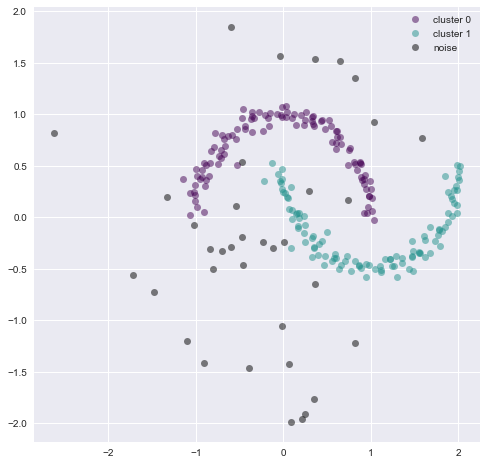

In [186]:
colors = [plt.cm.viridis(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    label=f'cluster {k}'
    if k == -1:
        label = 'noise'
        col = 'black'
    mask = labels == k
    plt.plot(X[mask, 0], X[mask, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', alpha=.5, label=label)
plt.legend();

** Important note** DBSCAN does require the MinPts and *epsilon* parameters to be tuned for the clustering.

Some quick notes from Wikipedia on general features of DBSCAN:
1. DBSCAN does not require one to specify the number of clusters in the data a priori, as opposed to k-means.
2. DBSCAN can find arbitrarily shaped clusters. It can even find a cluster completely surrounded by (but not connected to) a different cluster. Due to the MinPts parameter, the so-called single-link effect (different clusters being connected by a thin line of points) is reduced.
3. DBSCAN has a notion of noise, and is robust to outliers.
4. DBSCAN requires just two parameters and is mostly insensitive to the ordering of the points in the database. (However, points sitting on the edge of two different clusters might swap cluster membership if the ordering of the points is changed, and the cluster assignment is unique only up to isomorphism.)

## Hierarchical clustering

The hierarchical clustering dendrogram is obtained via an extremely simple algorithm. We begin by defining some sort of dissimilarity measure between each pair of observations. Most often, Euclidean distance is used. We'll define the algorithm for bottom-up, or *agglomerative* clustering.

The algorithm proceeds iteratively. Initially, each of the $n$ observations is treated as its own cluster. The two clusters that are most similar to each other are then fused so that there now are $n − 1$ clusters. Next the two clusters that are most similar to each other are fused again, so that there now are $n − 2$ clusters. The algorithm proceeds in this fashion until all of the observations belong to one single cluster.

This iterative linking can be represented using a tree-like structure know as a *dendrogram*. It represents the full merging history of each point, starting from the bottom, and working up to the top. 

Let's flesh the algorithm out a bit more explicitly:

1. Begin with $n$ observations
and a measure (such as Euclidean distance) of all the $\binom{n}{2} = n(n − 1)/2$ pairwise dissimilarities. Treat each
observation as its own cluster.
2. For $i = n, n − 1, . . . , 2$:
    1. Examine all pairwise inter-cluster dissimilarities among the $i$ clusters and identify the pair of clusters that are least dissimilar (that is, most similar). Fuse these two clusters. The dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion should be placed.
    2. Compute the new pairwise inter-cluster dissimilarities among the $i − 1$ remaining clusters.
    
The concept of dissimilarity between a pair of observations needs to be extended to a pair of groups of observations. This extension is achieved by developing the notion of linkage, which defines the dissimilarity between two groups of observations. The four most common types of linkage are complete, average, single, and centroid.

You can do a bit of further reading on each type if you're interested, but briefly, for instance, complete linkage is defined by:

Maximal intercluster dissimilarity. Compute all pairwise dis-
similarities between the observations in cluster A and the
observations in cluster B, and record the largest of these
dissimilarities.

Let's take a look into dendrograms and agglomerative clustering in the context of the very first dataset we examined using K means.

In [237]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from time import time

# recreate original data
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# generate the linkage matrix
# here we use the Ward variance minimization algorithm
Z = linkage(X, 'ward')

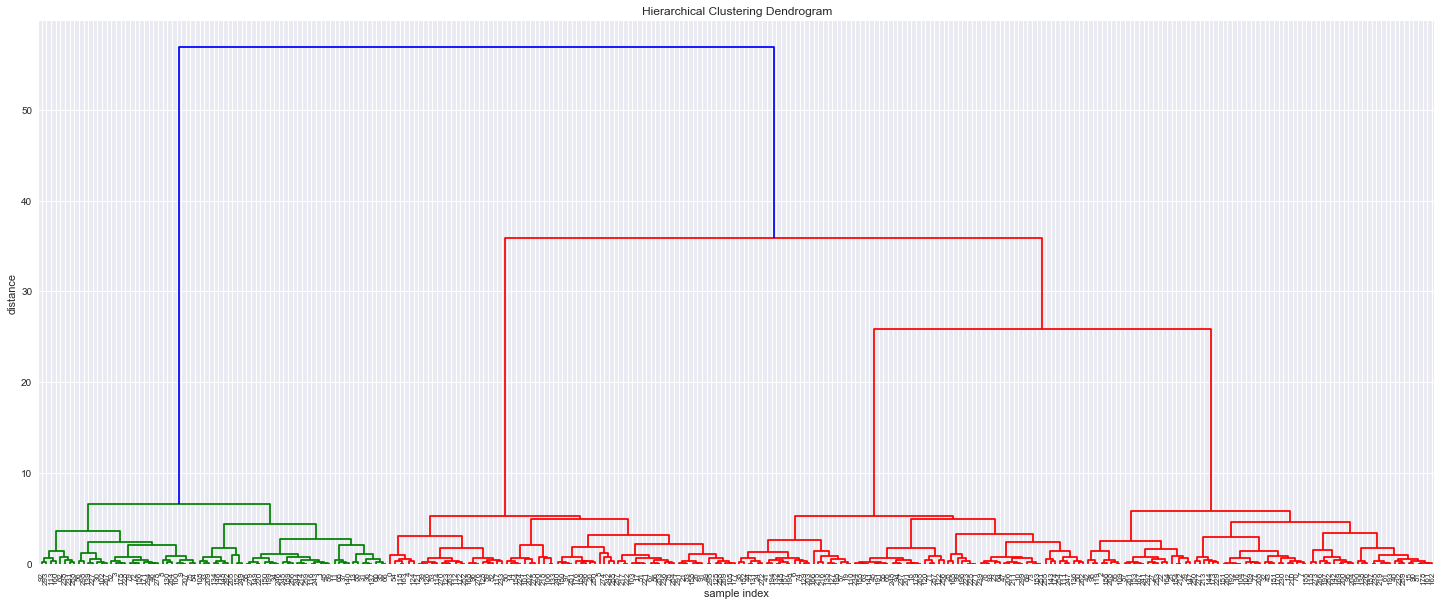

In [238]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [239]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

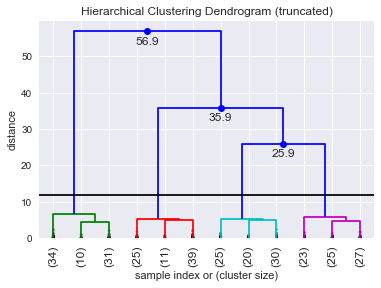

In [234]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=12
)
plt.show()

In [240]:
from scipy.cluster.hierarchy import fcluster
max_d = 12
clusters = fcluster(Z, max_d, criterion='distance')

Unique labels
(array([1, 2, 3, 4], dtype=int32), array([75, 75, 75, 75]))


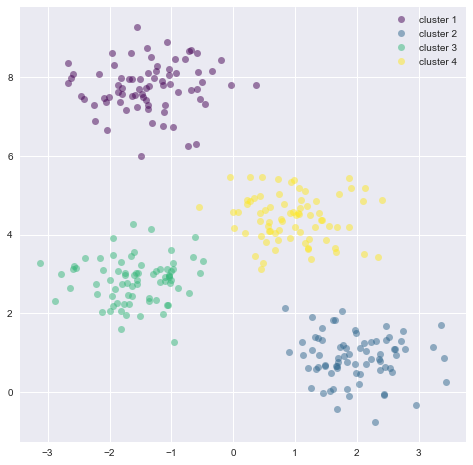

In [247]:
labels = clusters
unique_labels = set(labels)
print('Unique labels')
print(np.unique(labels, return_counts=True))

colors = [plt.cm.viridis(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(8, 8))

for k, col in zip(unique_labels, colors):
    label=f'cluster {k}'
    mask = labels == k
    plt.plot(X[mask, 0], X[mask, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', alpha=.5, label=label)
plt.legend();

In [248]:
clustering = AgglomerativeClustering(linkage='ward',
                                     n_clusters=4)
t0 = time()
clustering.fit(X)
print("%s : %.2fs" % ('ward', time() - t0))

ward : 0.00s


Unique labels
(array([0, 1, 2, 3]), array([75, 75, 75, 75]))


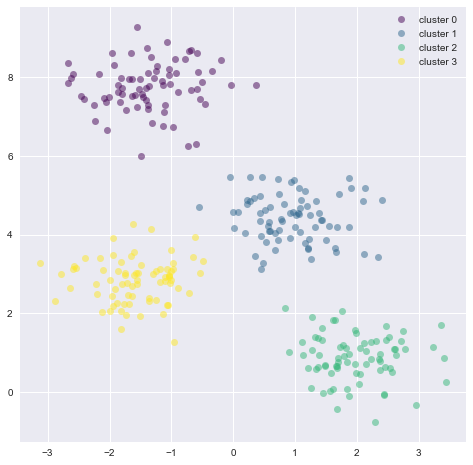

In [249]:
labels = clustering.labels_
unique_labels = set(labels)
print('Unique labels')
print(np.unique(labels, return_counts=True))

fig = plt.figure(figsize=(8, 8))

for k, col in zip(unique_labels, colors):
    label=f'cluster {k}'
    mask = labels == k
    plt.plot(X[mask, 0], X[mask, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', alpha=.5, label=label)
plt.legend();

## Silhouette Analysis (Cluster fitness)

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of $[-1, 1]$.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

A passable heuristic is to choose a number of clusters for which there are not clusters with below-average cluster scores present.

In [267]:
from sklearn.metrics import silhouette_samples, silhouette_score

def to_codebook(X, part):
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

centers = to_codebook(X, labels)
n_clusters = len(set(labels))

For n_clusters = 4 The average silhouette_score is : 0.6819938690643478


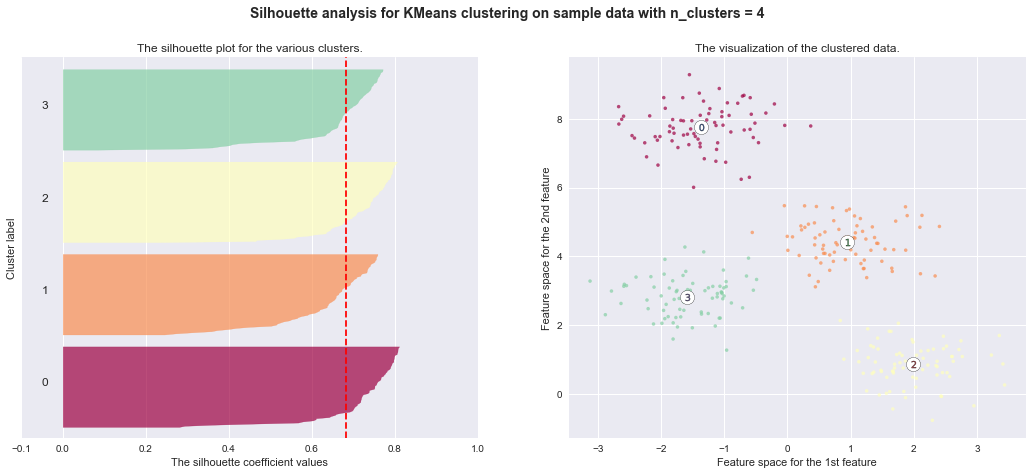

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = clustering
cluster_labels = labels

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.Spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = plt.cm.Spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold');

**Exercise:** Using the below K means dataset, use clustering — your choice of algorithm(s) — to obtain the cluster assignment that most accurately reflects the underlying digit classes. Verify the silhouette scoring for your digit assignment according to clusters, and check the accuracy of your best "classifier" using a confusion matrix.

In [269]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)